# Imports

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import re
import random

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from xgboost import XGBRegressor
import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
plt.rcParams["figure.figsize"] = (4, 3)

# Set pandas float display
pd.set_option("display.float_format", "{:.2f}".format)

In [4]:
RANDOM_STATE = 123

# Import data

In [5]:
train_df = pd.read_csv('train.csv', delimiter=',')
train_df.shape

(188533, 13)

In [6]:
test_df = pd.read_csv('test.csv')
test_df.shape

(125690, 12)

See data in tabular form

In [7]:
train_df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [8]:
train_df.pop('id')
test_df.pop('id')

,id
0,188533
1,188534
2,188535
3,188536
4,188537
...,...
125685,314218
125686,314219
125687,314220
125688,314221


In [9]:
# Inspect features and their data types
pd.DataFrame(train_df.columns, train_df.dtypes)

,0
object,brand
object,model
int64,model_year
int64,milage
object,fuel_type
object,engine
object,transmission
object,ext_col
object,int_col
object,accident


In [10]:
# Make price and milage float to treat them as continuos features for later use

train_df['price']=train_df['price'].astype('float')
train_df['milage'] = train_df['milage'].astype('float')

test_df['milage'] = test_df['milage'].astype('float')

### Outliers
Look at distributions of some continuos features.

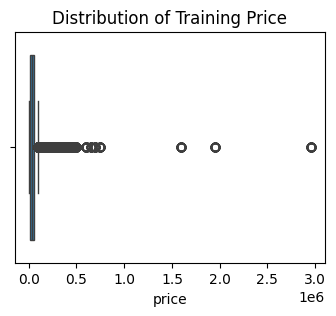

In [11]:
sns.boxplot(x=train_df['price'])
plt.title("Distribution of Training Price")
plt.show()

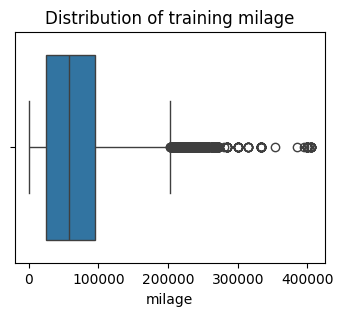

In [12]:
sns.boxplot(x=train_df['milage'])
plt.title("Distribution of training milage")
plt.show()

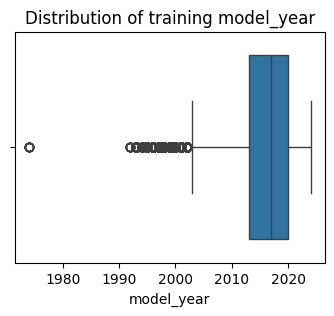

In [13]:
sns.boxplot(x=train_df['model_year'])
plt.title("Distribution of training model_year")
plt.show()

It seems price and milage has extreme outliers.

In [14]:
def handle_outliers(col, limit=2):
    '''
    Truncate outliers according to limit argument
    Truncate here means set values to 0

    Args:
    col (Series): Column to truncate
    limit (int) : Multiple of standard deviation at which to truncate column
    '''
    x = col.copy()
    x = x.astype(float)

    mean = x.mean()
    std_dev = x.std()
    lower_bound = mean - (limit * std_dev)
    upper_bound = mean + (limit * std_dev)

    x[x < lower_bound] = lower_bound
    x[x > upper_bound] = upper_bound

    return x

Truncate outliers from above columns

In [15]:
train_df['price'] = handle_outliers(train_df['price'], 2)
train_df['milage'] = handle_outliers(train_df['milage'], 2)
train_df['model_year'] = handle_outliers(train_df['model_year'], 2)

After truncating outliers upto 2 * std dv, Let's see boxplot of resulting distribution of features.

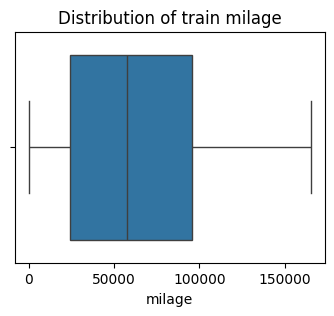

In [16]:
sns.boxplot(x=train_df['milage'])
plt.title("Distribution of train milage")
plt.show()

Visualize price and model_year outliers

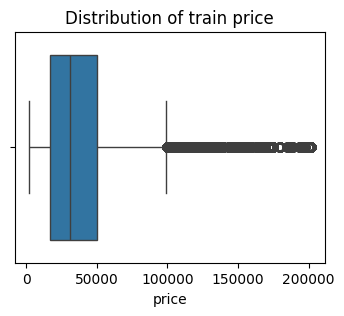

In [17]:
sns.boxplot(x=train_df['price'])
plt.title("Distribution of train price")
plt.show()

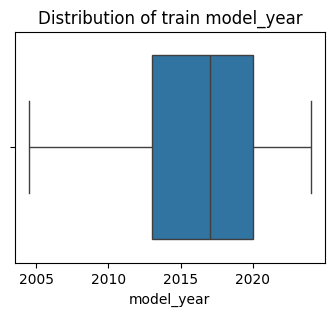

In [18]:
sns.boxplot(x=train_df['model_year'])
plt.title("Distribution of train model_year")
plt.show()

# Clean missing values

In [19]:
def check_null(df):
  ''' Returns DataFrame containg isnull() Series for both Train and Test set '''
  return pd.DataFrame({'No. null values' : df.isnull().sum()})

In [20]:
# Check for missing values
check_null(train_df)

,No. null values
brand,0
model,0
model_year,0
milage,0
fuel_type,5083
engine,0
transmission,0
ext_col,0
int_col,0
accident,2452


In [21]:
# Cleans the categorical and continuos data for missing values using imputation

class Cleaner():
    """
    Handles missing values in categorical and continuous features.

    The Cleaner class automatically detects categorical and continuous variables
    in a given DataFrame and imputes missing values using appropriate strategies:
    - Categorical features → imputed using mode (most frequent value).
    - Continuous features → imputed using mean.

    Args:
        df (pd.DataFrame): The input DataFrame to clean.
        categoricals (list): List of detected categorical feature names.
        continuos (list): List of detected continuous feature names.
        categoricals_imputed (list): Tracks categorical features already imputed.
        continuos_imputed (list): Tracks continuous features already imputed.
        mean_imputer (SimpleImputer): Imputer object with mean strategy.
        mode_imputer (SimpleImputer): Imputer object with most frequent strategy.

    """
    def __init__(self, df):
      self.df = df
      self.categoricals = []
      self.continuos = []
      self.categoricals_imputed = []
      self.continuos_imputed = []

      self.mean_imputer = SimpleImputer(strategy='mean')
      self.mode_imputer = SimpleImputer(strategy='most_frequent')

      self.update_vars()


    def update_vars(self, extra_categoricals=[], extra_continuos=[]):
        """
        Updates the lists of categorical and continuous variables.

        - Categorical features are identified as columns with dtype `int`, `object`, or `category`.
        - Continuous features are all remaining columns (typically floats).
        - Optional overrides can be provided to force certain columns into
          categorical or continuous lists.

        Args:
            extra_categoricals (list, optional): Columns to be explicitly treated as categorical.
            extra_continuos (list, optional): Columns to be explicitly treated as continuous.
        """
        self.categoricals = list(set(self.categoricals) | set(self.df.select_dtypes(include=[int, object, 'category']).columns))

        if extra_categoricals:
            self.categoricals = list(set(self.categoricals) | set(extra_categoricals))

        self.continuos = [col for col in self.df.columns if col not in self.categoricals]
        if extra_continuos:
            self.continuos = list(set(self.continuos) | set(extra_continuos))


    def clean_categoricals(self):
        """
        Imputes missing values in categorical features using mode (most frequent value).

        - Detects categorical features not yet imputed.
        - Applies mode imputation to fill missing values.
        - Updates the `categoricals_imputed` list to prevent repeated imputation.
        """
        self.update_vars()
        categorical_missing_vars = list(filter(lambda x: x not in self.categoricals_imputed, self.categoricals))

        if categorical_missing_vars:
          print(f'Categorical_missing_vars: {categorical_missing_vars}')
          self.df[categorical_missing_vars] = self.mode_imputer.fit_transform(self.df[categorical_missing_vars])
          self.categoricals_imputed += categorical_missing_vars


    def clean_continuos(self):
        """
        Imputes missing values in continuous features using mean.

        - Detects continuous features not yet imputed.
        - Applies mean imputation to fill missing values.
        - Updates the `continuos_imputed` list to prevent repeated imputation.
        """
        self.update_vars()

        continuos_missing_vars = list(filter(lambda x: x not in self.continuos_imputed, self.continuos))

        if continuos_missing_vars:
          print(f'Continuos_missing_vars: {continuos_missing_vars}')
          self.df[continuos_missing_vars] = self.mean_imputer.fit_transform(self.df[continuos_missing_vars])
          self.continuos_imputed += continuos_missing_vars


In [22]:
cleaner = Cleaner(df = train_df)

In [23]:
cleaner.clean_categoricals()

Categorical_missing_vars: ['transmission', 'accident', 'engine', 'fuel_type', 'clean_title', 'brand', 'int_col', 'model', 'ext_col']


In [24]:
# Ensure missing values are imputed
check_null(train_df)

,No. null values
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


# Feature Engineering

Functions to extract features from original dataset

In [25]:
# Categorical
def get_automatic(string):
    string = string.lower()
    if 'a/t' in string or 'automatic' in string or 'at' in string:
        return 1
    else:
        return 0

In [26]:
# Categorical
def get_gears(string):
    match = re.search(r'^(\d+)-Speed', string, re.IGNORECASE)
    if match:
        gears = match.group(1)
        return int(gears)
    else:
        return None

In [27]:
# Contiunuos
def get_hp(engine):
    match = re.search(r'([\d.]+)HP', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [28]:
# Continuos
def get_L(engine):
    match = re.search(r'([\d.]+)L', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [29]:
# Categorical
def get_cyl(engine):
    match = re.search(r'([\d.]+)?\s?(?:Cylinder|Cyl|Cylinders)', engine, re.IGNORECASE)
    if match:
      return int(match.group(1))
    else:
      return None

In [30]:
# Categorical
def is_electric(engine):
    if 'electric' in engine.lower():
      return 1
    else:
      return 0

In [31]:
# Continuos
def num_valves(engine):
    match = re.search(r'([\d+])V', engine)
    if match:
      return float(match.group(1))
    else:
      return None

In [32]:
# Categorical
def is_accident(accident):
    if type(accident) == str:
        if 'accident' in accident.lower():
          return 1
        else:
          return 0
    else:
        return None

In [33]:
# Create features and insert into dataframe

def create_features(df):
    ''' Extract features using pre-defined functions
        Updates dataframe inplace '''

    df['automatic'] = df['transmission'].apply(get_automatic)
    df['gears'] = df['transmission'].apply(get_gears)
    df['hp'] = df['engine'].apply(get_hp)
    df['L'] = df['engine'].apply(get_L)
    df['cylinders'] = df['engine'].apply(get_cyl)
    df['accident'] = df['accident'].apply(is_accident)
    df['electric'] = df['engine'].apply(is_electric)
    df['valves'] = df['engine'].apply(num_valves)

    return df

def create_interactions(df):
    """
    Generate interaction and ratio-based features to capture relationships
    between existing attributes.
    Updates df inplace.


    Args:
    df (DataFrame) : DataFrame to add new features
    """

    df['hp/l'] = np.where(df['L'] != 0, df['hp'] / df['L'], None).astype('float')
    df['mil/l'] = np.where(df['L'] != 0, df['milage'] / df['L'], None).astype('float')
    df['mil/hp'] = np.where(df['hp'] != 0, df['milage'] / df['hp'], None).astype('float')
    df['l/cyl'] = np.where(df['cylinders'] != 0, df['L'] / df['cylinders'], None).astype('float')
    df['hp/gears'] = np.where(df['gears'] != 0, df['hp'] / df['gears'], None).astype('float')
    df['mil/gears'] = np.where(df['gears'] != 0, df['milage'] / df['gears'], None).astype('float')
    df['mil/cyl'] = np.where(df['cylinders'] != 0, df['milage'] / df['cylinders'], None).astype('float')

    df['hp*automatic'] = df['hp'] * df['automatic']
    df['cyl*gears'] = df['cylinders'] * df['gears']

    df['carAge'] = pd.Series(2024 - df['model_year']).astype('int')
    df['mil/year'] = np.where(df['carAge'] != 0, df['milage'] / df['carAge'], None).astype('float')
    df['hp*accident'] = pd.Series(df['hp'] * df['accident']).astype('float')
    df['accident*carAge'] = pd.Series(df['accident'] * df['carAge']).astype('float')
    df['acc*milage'] = pd.Series(df['accident'] * df['milage']).astype('float')

    df['mil*carAge'] = pd.Series(df['milage'] * df['carAge']).astype('float')
    df['hp*mil'] = pd.Series(df['hp'] * df['milage']).astype('float')

    return df


In [34]:
create_features(train_df)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,automatic,gears,hp,L,cylinders,electric,valves
0,MINI,Cooper S Base,2007.00,165301.61,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,0,Yes,4200.00,1,NaN,172.00,1.60,4.00,0,NaN
1,Lincoln,LS V8,2004.51,143250.00,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,1,Yes,4999.00,1,NaN,252.00,3.90,8.00,0,NaN
2,Chevrolet,Silverado 2500 LT,2004.51,136731.00,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,0,Yes,13900.00,1,NaN,320.00,5.30,8.00,0,NaN
3,Genesis,G90 5.0 Ultimate,2017.00,19500.00,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,0,Yes,45000.00,0,NaN,420.00,5.00,8.00,0,NaN
4,Mercedes-Benz,Metris Base,2021.00,7388.00,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,0,Yes,97500.00,1,7.00,208.00,2.00,4.00,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Cadillac,Escalade ESV Platinum,2017.00,49000.00,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,0,Yes,27500.00,0,NaN,420.00,6.20,8.00,0,NaN
188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018.00,28600.00,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,1,Yes,30000.00,1,8.00,385.00,3.00,6.00,0,NaN
188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021.00,13650.00,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,0,Yes,86900.00,1,7.00,469.00,4.00,8.00,0,NaN
188531,Audi,S5 3.0T Prestige,2022.00,13895.00,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,0,Yes,84900.00,1,1.00,NaN,3.00,NaN,0,NaN


We'll treat L, cylinders, gears features as categoricals as they have less unique values.

In [35]:
# Check missing values in new features
check_null(train_df)

,No. null values
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


### Clean newly created features

In [36]:
# We will treat some suitable variables as categorical
cleaner.update_vars(extra_categoricals = ['L', 'cylinders', 'gears'])

In [37]:
cleaner.clean_categoricals()
cleaner.clean_continuos()

Categorical_missing_vars: ['gears', 'L', 'automatic', 'cylinders', 'electric']
Continuos_missing_vars: ['model_year', 'milage', 'price', 'hp', 'valves']


In [38]:
check_null(train_df)

,No. null values
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


### Create Interaction features

In [39]:
# Create interaction features
train_df = create_interactions(train_df)

In [40]:
cleaner.update_vars()

# Truncate outliers from newly created continuos features
non_impute_cols = [col for col in train_df.columns if col in cleaner.continuos and col not in cleaner.continuos_imputed]

for col in non_impute_cols:
  train_df[col] =  handle_outliers(train_df[col], 3)

In [41]:
cleaner.clean_continuos()

Continuos_missing_vars: ['hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil']


Some features might have skewed distributions, specifically righly skewed distribution. These can be log transformed to make them go near normal distribution.

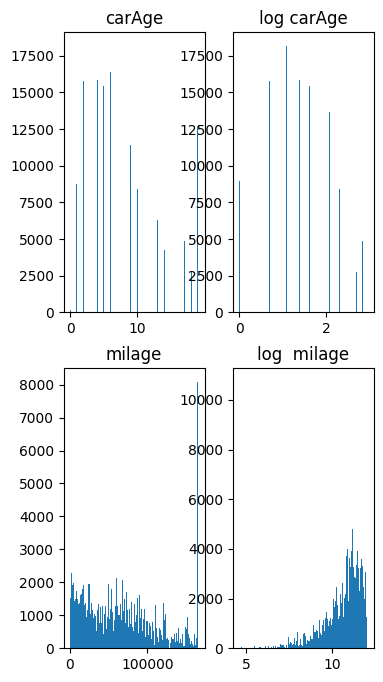

In [42]:
# Some features with rightly skewed data can be log transformed
fig, axs = plt.subplots(2, 2, figsize=(4, 8))

# carAge distribution
axs[0, 0].hist(train_df['carAge'], bins=200)
axs[0, 0].set_title('carAge')

axs[1, 0].hist(train_df['milage'], bins=200)
axs[1, 0].set_title('milage')

# milage is right skewed. Log transformation could be used.
carAge = np.where(train_df['carAge'] != 0, train_df['carAge'], 1).astype('float')
milage = np.where(train_df['milage'] != 0, train_df['milage'], 1).astype('float')

log_carAge = np.log(carAge)
log_milage = np.log(milage)

axs[0, 1].hist(log_carAge, bins=200)
axs[0, 1].set_title('log carAge')

axs[1,1].hist(log_milage, bins=200,)
axs[1,1].set_title('log  milage')
plt.show()

log transformation will be applied in later function.

#### Add binning to milage

In [43]:
# Get range of values
print(f'min: {np.min(milage)}, max:{np.max(milage)}')

min: 100.0, max:165301.61132529768


In [44]:
# Add binning to milage and categorize ordinally
bins = [99.0, 300.0, 700.0, 1000.0, 3000.0, 7000., 10000.0, 20000., 35000., 50000.0, 75000, 100000.0, 125000.0, 150000., 175000, 200000.0, 250000.0]
intervals = {pd.Interval(bins[i], bins[i+1], closed='left') : i for i in range(len(bins) - 1)}

train_binned_milage = pd.cut(train_df['milage'], bins, right=False)

train_df['binned_milage'] = train_binned_milage.map(lambda x: intervals[x])

Assign classes to brands according to their mean prices

In [45]:
# Get range of values
print(np.min(train_df['price']), np.max(train_df['price']))

2000.0 201517.06068646687


In [46]:
# Classes will be ordinally categorized

# Define bins
bins = [1000.0, 5000.0, 10000.0, 25000.0, 50000.0, 75000., 100000.0, 125000., 150000.0, 175000., 200000.0, 225000., 250000.0, 275000.0, 300000.0]

binned_prices = pd.cut(train_df['price'], bins, right=False)

# Create interval mapping
intervals = {pd.Interval(bins[i], bins[i+1], closed='left'): i for i in range(len(bins) - 1)}

brand_avg_price = train_df.groupby('brand')['price'].mean().to_dict()   # {'brand_name' : mean_price}

def get_class(mean_price):
    for interval, class_ in intervals.items():
        if mean_price in interval:
          return class_

train_df['brand_class'] = train_df['brand'].map(lambda x: get_class(brand_avg_price[x]))


Additional features to imprve model performance

In [47]:
def additional_features(df):
    df['AverageMilage'] = df.groupby("brand")['milage'].transform('mean')
    df['BrandFreq'] = df.groupby('brand')['brand'].transform('count')/df['brand'].count()

    brand_count = df.groupby('brand')['brand'].count().to_dict()
    df['brand_count'] = df['brand'].map(brand_count)

    brand_avg_mil = df.groupby('brand')['milage'].mean().to_dict()
    df['brand_avg_mil'] = df['brand'].map(brand_avg_mil)

    df['log_milage'] = np.log(df['milage'])

    df['logL'] = np.log(df['L'])

    df['logAge'] = np.log1p(df['carAge'])

    return df


In [48]:
train_df = additional_features(train_df)

In [49]:
cleaner.update_vars()

# Trucnate outliers
non_impute_cols = [col for col in train_df.columns if col in cleaner.continuos and col not in cleaner.continuos_imputed]

for col in non_impute_cols:
  train_df[col] =  handle_outliers(train_df[col], 3)


In [50]:
check_null(train_df)

,No. null values
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


In [51]:
cleaner.clean_continuos()

Continuos_missing_vars: ['AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge']


## Label encode categoricals

In [52]:
# Label categorical features
for colname in cleaner.categoricals:
    train_df[colname], _ = train_df[colname].factorize()


In [53]:
X = train_df.copy()
y = X.pop('price')

In [54]:
X.shape, y.shape

((188533, 43), (188533,))

#### PCA

In [55]:
# Standardize the data (important for PCA)
X_pca = X.copy()

scaler_pca = StandardScaler()

X_pca[X_pca.select_dtypes(include='float').columns] = scaler_pca.fit_transform(X_pca.select_dtypes(include='float'))

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
X_pca_components = pca.fit_transform(X_pca)

# Explained Variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print("Explained Variance Ratio:", explained_variance)

# Convert to DataFrame for better readability
pca_df = pd.DataFrame(data=X_pca_components, columns=['PC1', 'PC2'])
X = pd.concat([X, pca_df], axis=1)

Explained Variance Ratio: 0.9915589890715872


In [56]:
cleaner.categoricals.extend(['PC1', 'PC2'])

In [57]:
# See loadings

# Get the principal components (PCs)
components = pca.components_
print(components.shape)

# Create a DataFrame for easy visualization
components_df = pd.DataFrame(components, columns=X_pca.columns, index=['PC1', 'PC2'])

# Display the loadings (contributions of each feature to each component)
components_df

(2, 43)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,hp*mil,binned_milage,brand_class,AverageMilage,BrandFreq,brand_count,brand_avg_mil,log_milage,logL,logAge
PC1,0.01,0.98,-0.00,0.00,0.00,0.21,0.00,0.01,0.00,0.00,...,-0.00,-0.00,-0.00,0.00,-0.00,0.01,0.00,0.00,-0.00,0.00
PC2,0.01,-0.21,-0.00,0.00,0.00,0.98,0.00,-0.00,0.00,0.00,...,0.00,-0.00,0.00,0.00,-0.00,0.01,0.00,0.00,0.00,0.00


Create features inspired by results of PCA

In [58]:
model_engine = np.where(X['engine'] != 0, X['model'] / X['engine'], 0)
brand_engine = X['BrandFreq'] * X['engine']

Calculate mutual informtion score to see if this feature is significant

In [59]:
model_engine_mi = mutual_info_regression(pd.DataFrame(model_engine), y)
brand_engine_mi = mutual_info_regression(pd.DataFrame(brand_engine), y)

In [60]:
model_engine_mi, brand_engine_mi

(array([0.26036998]), array([0.4261276]))

brand_engine seems to have influence on target, add it to dataset

In [61]:
X['brandfreq_engine'] = brand_engine

#### K-means Clustering

In [62]:
# Add cluster feature
c_scaler = StandardScaler()

kmeans = KMeans(n_clusters=3, n_init=10)

XC = [col for col in X.columns if col not in cleaner.categoricals]
XC = X[XC]
XC = c_scaler.fit_transform(XC)
X['Cluster'] = kmeans.fit_predict(XC)
X['Cluster'] = X['Cluster'].astype('int')

In [63]:
cleaner.categoricals.extend(['Cluster'])

In [64]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X, y, discrete_features='auto')

Select features with mutual information score greater than or equal to 0.4.

In [69]:
X.columns[mi >= 0.4]

Index(['model_year', 'milage', 'engine', 'transmission', 'hp', 'hp/l', 'mil/l',
       'mil/hp', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'carAge',
       'mil*carAge', 'binned_milage', 'log_milage', 'logAge',
       'brandfreq_engine', 'Cluster'],
      dtype='object')

In [70]:
selected_features = X.columns[mi >= 0.4].tolist()

# Split the data


In [ ]:
X = X[selected_features]

In [71]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

(150826, 47) (18854, 47)


# Standardize the data
Standardize only contunios features.

In [72]:
# Scale train continuos features
continuos_features_to_scale = [col for col in X.columns if col not in cleaner.categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

scalerTrain = StandardScaler()
X_train = scalerTrain.fit_transform(X_train)
X_val = scalerTrain.transform(X_val)
X_test = scalerTrain.transform(X_test)


Features to be scaled: ['model_year', 'milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge', 'brandfreq_engine']


# Model Training

In [76]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [77]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, 'relu', kernel_regularizer=tf.keras.regularizers.L2(2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
])

model.compile(loss=rmse, optimizer=tf.keras.optimizers.Adam(), metrics=[])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.0000e+00 - loss: 53136.0820 - val_accuracy: 0.0000e+00 - val_loss: 52505.6055
Epoch 2/5
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.0000e+00 - loss: 53374.3242 - val_accuracy: 0.0000e+00 - val_loss: 52502.0156
Epoch 3/5
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.0000e+00 - loss: 53489.2930 - val_accuracy: 0.0000e+00 - val_loss: 52498.4023
Epoch 4/5
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0000e+00 - loss: 53503.5781 - val_accuracy: 0.0000e+00 - val_loss: 52494.7695
Epoch 5/5
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.0000e+00 - loss: 53355.0781 - val_accuracy: 0.0000e+00 - val_loss: 52491.1875


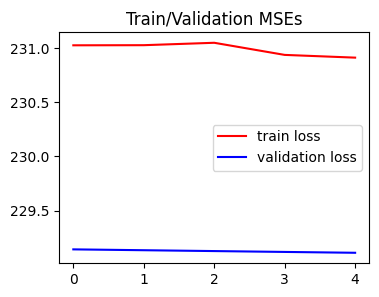

In [78]:
t_loss = np.sqrt(history.history['loss'])
v_loss = np.sqrt(history.history['val_loss'])
plt.plot(t_loss, c='r', label='train loss')
plt.plot(v_loss, c='b', label='validation loss')
plt.title('Train/Validation MSEs')
plt.legend()
plt.show()

### XGB Regressor Model

In [81]:
xgb_model = XGBRegressor(
              enable_categorical=True,
                     )

# Hyperparameters Search

In [83]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_distributions = {
    'n_estimators': np.arange(100, 1000, 100),         # Number of trees
    'max_depth': np.arange(3, 10),                     # Tree depth
    'learning_rate': np.linspace(0.01, 0.3, 10),       # Learning rate (eta)
    'subsample': np.linspace(0.5, 1.0, 5),             # Subsample ratio
    'colsample_bytree': np.linspace(0.5, 1.0, 5),      # Column subsampling
    'gamma': np.linspace(0, 5, 10),                    # Minimum loss reduction
    'alpha': np.linspace(0, 1, 10),                    # L1 regularization
    'lambda': np.linspace(0, 1, 10)                    # L2 regularization
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of random combinations to try
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=3,                      # 3-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Reproducibility
    n_jobs=-1,
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': np.float64(0.75), 'n_estimators': np.int64(800), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.01), 'lambda': np.float64(1.0), 'gamma': np.float64(5.0), 'colsample_bytree': np.float64(0.625), 'alpha': np.float64(1.0)}
Best Score: -673261088.7966733


In [84]:
best_parameters = {'subsample': np.float64(0.75), 'n_estimators': np.int64(800), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.01), 'lambda': np.float64(1.0), 'gamma': np.float64(5.0), 'colsample_bytree': np.float64(0.625), 'alpha': np.float64(1.0)}
BestScore: -673261088.7966733

Obtained by running RandomSearchCV for 23 mins with t4 gpu
```python  
best_parameters= {'subsample': 0.875,
                  'n_estimators': 900,
                  'max_depth': 7,
                  'learning_rate': 0.042222222222222223,
                  'lambda': 100.0,
                  'gamma': 1.6666666666666667,
                  'colsample_bytree': 0.3,
                  'alpha': 0.4444444444444444,
                  'subsample': 0.3,
                  'alpha':100,
                  'min_child_weight':10,
                     }
```                     


# Manual Hyperparameter tuning (Optional, Not used for model training)

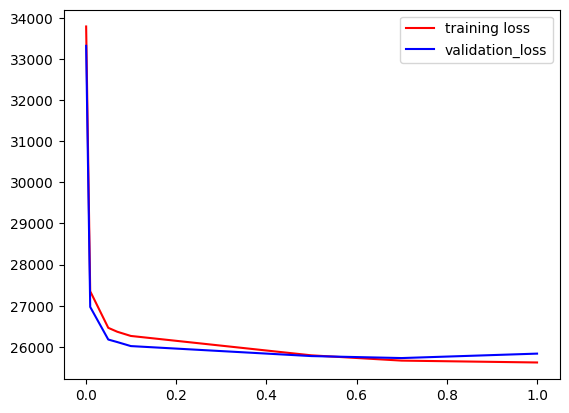

In [ ]:
rates = [0.001, 0.01, 0.05, 0.07, 0.1, 0.5, 0.7, 1.0]
cv = []
tr = []

for rate in rates:
    xgb_model = XGBRegressor(learning_rate= rate,
                        max_depth = 2,
                        n_estimators = 200,
                        enable_categorical=True,
                     )

    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))

plt.plot(rates, tr, c='r', label='training loss')
plt.plot(rates, cv, c='b', label='validation_loss')
plt.legend()
plt.show()

In [ ]:
optimum_lrate = rates[np.argmin(cv)]
optimum_lrate

0.7

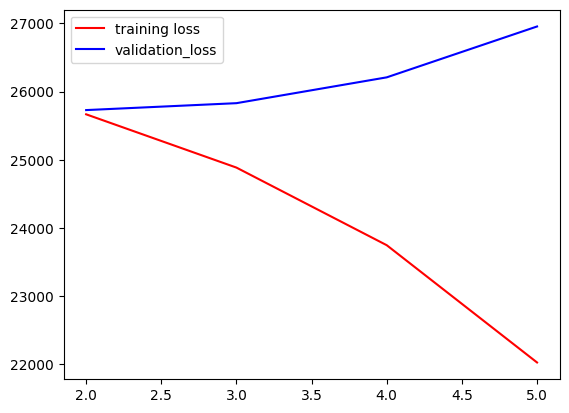

In [ ]:
depths = [2, 3, 4, 5]
cv = []
tr = []

for depth in depths:
    xgb_model = XGBRegressor(learning_rate= optimum_lrate,
                        max_depth = depth,
                        n_estimators = 200,
                        enable_categorical=True,
                     )
    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))

plt.plot(depths, tr, c='r', label='training loss')
plt.plot(depths, cv, c='b', label='validation_loss')
plt.legend()
plt.show()

In [ ]:
optimum_depth = depths[np.argmin(cv)]
optimum_depth

2

In [ ]:
subsamples = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cv = []
tr = []

for fraction in subsamples:
    xgb_model = XGBRegressor(learning_rate= optimum_lrate,
                        max_depth = optimum_depth,
                        n_estimators = 200,
                        enable_categorical=True,
                        subsample= fraction,
                     )

    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))


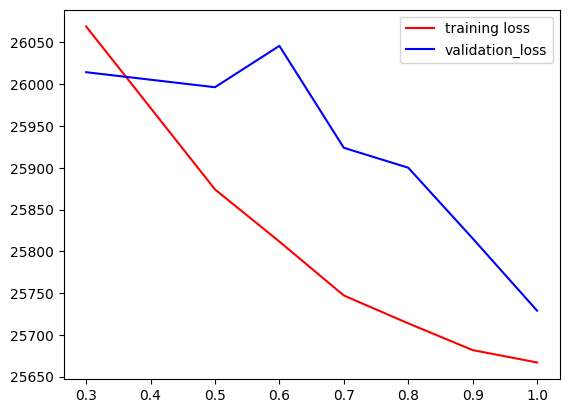

In [ ]:
plt.plot(subsamples, tr, c='r', label='training loss')
plt.plot(subsamples, cv, c='b', label='validation_loss')
plt.legend()
plt.show()

In [ ]:
optimum_subsample = subsamples[np.argmin(cv)]
optimum_subsample

1.0

In [ ]:
lambdas = [0.001, 0.05, 0.1, 0.5, 0.7, 1.0, 3.0, 7., 10., 20.]
cv = []
tr = []

for lambd in lambdas:
    xgb_model = XGBRegressor(learning_rate= optimum_lrate,
                        max_depth = optimum_depth,
                        n_estimators = 200,
                        enable_categorical=True,
                        subsample= optimum_subsample,
                        reg_lambda=lambd
                     )

    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))


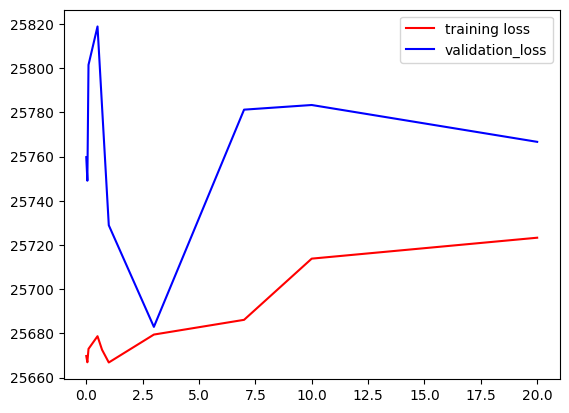

In [ ]:
plt.plot(lambdas, tr, c='r', label='training loss')
plt.plot(lambdas, cv, c='b', label='validation_loss')
plt.legend()
plt.show()

In [ ]:
optimum_lambda = lambdas[np.argmin(cv)]
optimum_lambda

3.0

# Final Model

In [85]:
xgb_model = XGBRegressor(**best_parameters)

In [87]:
# Train model
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=np.float64(1.0), base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.625), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(5.0), grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=np.float64(1.0),
             learning_rate=np.float64(0.01), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=np.int64(6), max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=np.int64(800), ...)

In [88]:
# Calculate RMSE
ypred = xgb_model.predict(X_train)
xgb_train_mse = mean_squared_error(y_train, ypred)

print(f'Train RMSE: {np.sqrt(xgb_train_mse)}')

Train RMSE: 24963.236376383058


In [96]:
ypred = xgb_model.predict(X_train)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, ypred))

ypred = xgb_model.predict(X_val)
xgb_cv_rmse = np.sqrt(mean_squared_error(y_val, ypred))


print(f'train RMSE: {xgb_train_rmse}\nValidation RMSE: {xgb_cv_rmse}')
print(f'Difference: {abs(xgb_train_rmse - xgb_cv_rmse):.4f}')

train RMSE: 24963.236376383058
Validation RMSE: 25401.51691514486
Difference: 438.2805


Visualize distribution of training targets, predicted targets and test targets.

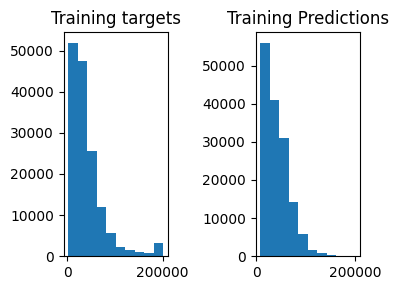

In [103]:
train_pred = xgb_model.predict(X_train)

fig, axs = plt.subplots(1, 2)

axs[0].hist(y_train)
axs[0].set_title('Training targets')

axs[1].hist(train_pred)
axs[1].set_title('Training Predictions')

plt.tight_layout()
plt.show()

### Submission

In [ ]:
pred = xgb_model.predict(test)

In [ ]:
submision = pd.DataFrame({'id': id, 'price': pred})

In [ ]:
submision.to_csv('submission.csv', index=False)

### Thank you.